In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.svm import  SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.pipeline import make_pipeline
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 1000)

In [89]:
training = pd.read_csv('train.csv')
train_data = training.copy()
test_data = pd.read_csv('test.csv')
train_data.head(10)

,Id,Age,Attrition,BusinessTravel,Department,...,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,CommunicationSkill,Behaviour
0,1,30,0,Non-Travel,Research & Development,...,7,6,7,4,1
1,2,36,0,Travel_Rarely,Research & Development,...,2,1,1,2,1
2,3,55,1,Travel_Rarely,Sales,...,7,7,3,5,1
3,4,39,0,Travel_Rarely,Research & Development,...,7,1,7,4,1
4,5,37,0,Travel_Rarely,Research & Development,...,7,7,8,1,1
5,6,31,0,Travel_Rarely,Sales,...,7,5,2,2,1
6,7,32,1,Travel_Rarely,Research & Development,...,2,1,2,1,1
7,8,33,0,Travel_Rarely,Research & Development,...,4,0,2,5,1
8,9,35,0,Travel_Frequently,Sales,...,2,0,2,4,1
9,10,21,1,Travel_Rarely,Sales,...,0,1,0,5,1


In [90]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1628 entries, 0 to 1627
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Id                       1628 non-null   int64 
 1   Age                      1628 non-null   int64 
 2   Attrition                1628 non-null   int64 
 3   BusinessTravel           1628 non-null   object
 4   Department               1628 non-null   object
 5   DistanceFromHome         1628 non-null   int64 
 6   Education                1628 non-null   int64 
 7   EducationField           1628 non-null   object
 8   EmployeeNumber           1628 non-null   int64 
 9   EnvironmentSatisfaction  1628 non-null   int64 
 10  Gender                   1628 non-null   object
 11  JobInvolvement           1628 non-null   int64 
 12  JobRole                  1628 non-null   object
 13  JobSatisfaction          1628 non-null   int64 
 14  MaritalStatus            1628 non-null  

In [91]:
print(train_data.describe(include= "all"))

                 Id          Age    Attrition BusinessTravel  \
count   1628.000000  1628.000000  1628.000000           1628   
unique          NaN          NaN          NaN              3   
top             NaN          NaN          NaN  Travel_Rarely   
freq            NaN          NaN          NaN           1105   
mean     814.500000    35.645577     0.482187            NaN   
std      470.107435     9.481794     0.499836            NaN   
min        1.000000    18.000000     0.000000            NaN   
25%      407.750000    29.000000     0.000000            NaN   
50%      814.500000    34.000000     0.000000            NaN   
75%     1221.250000    42.000000     1.000000            NaN   
max     1628.000000    60.000000     1.000000            NaN   

                    Department  ...  YearsInCurrentRole  \
count                     1628  ...         1628.000000   
unique                       3  ...                 NaN   
top     Research & Development  ...                 Na

In [92]:
train_id = train_data.Id
train_data = train_data.drop(['Behaviour','Id'],axis = 1)

test_id = test_data.Id
test_data = test_data.drop(['Behaviour','Id'],axis = 1)

In [93]:
train_data['PerformanceRating'] = train_data['PerformanceRating'].apply(lambda x: 0 if x == 3 else 1)
test_data['PerformanceRating'] = test_data['PerformanceRating'].apply(lambda x: 0 if x == 3 else 1)

<AxesSubplot:>

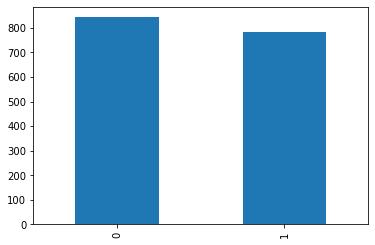

In [94]:
train_data['Attrition'].value_counts().plot(kind = 'bar')


In [95]:
print('Number of duplicates: ',train_data.duplicated().sum())

Number of duplicates:  628


<AxesSubplot:>

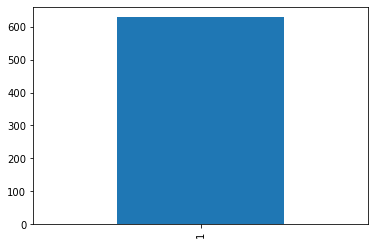

In [96]:
train_data[train_data.duplicated()]['Attrition'].value_counts().plot(kind = 'bar')

New train set:  (1000, 27)


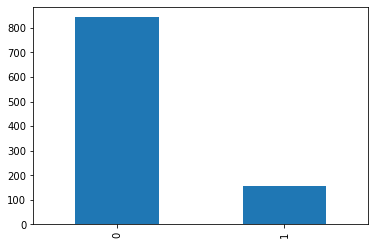

In [97]:
train_unq = train_data.drop_duplicates()
print('New train set: ',train_unq.shape)
X = train_unq.drop('Attrition',axis = 1)
y = train_unq['Attrition']
y.value_counts().plot(kind = 'bar')
plt.show()

In [70]:
# check version number
import imblearn
print(imblearn.__version__)

0.7.0


In [98]:
# Standard Scaling
skf = StratifiedKFold(n_splits = 10,random_state=42,shuffle=True)

categorical = [f for f in training.columns if training[f].dtype == object]
numeric = [f for f in X.columns if f not in categorical+['Id','Attrition','Behaviour','PerformanceRating']]

pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric))


In [99]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

over = SMOTE(sampling_strategy=0.2)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('p',pre_pipe),('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X, y = pipeline.fit_resample(X, y)

In [100]:
pipe_rf = make_pipeline(RandomForestClassifier())

pipe_svc = make_pipeline(SVC(probability=True))


print('RF: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_rf,scoring='roc_auc')))

print('SVC:',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

RF:  0.8150297853098459
SVC: 0.8167774195239593


SVC:  0.809829152249135


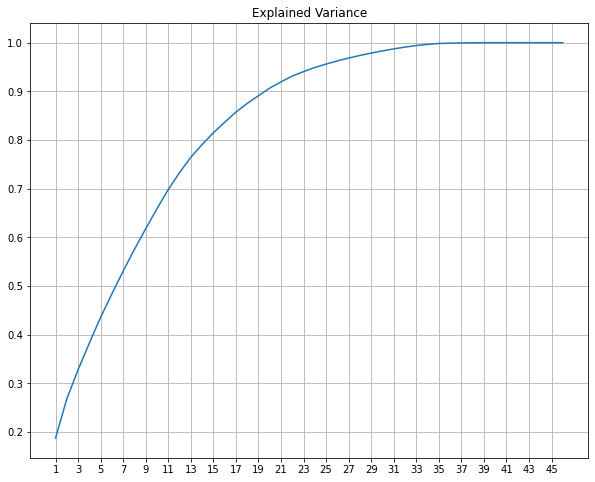

In [79]:
n = 46
pipe_svc = make_pipeline(PCA(n_components=n),SVC(probability=True,C = 1,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

plt.figure(figsize=(10,8))
pipe_svc.fit(X,y)
plt.plot(range(1,n+1),pipe_svc.named_steps['pca'].explained_variance_ratio_.cumsum())
plt.xticks(range(1,n+1,2))
plt.title('Explained Variance')
plt.grid()
plt.show()

In [101]:
n = 29
#pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric),remainder = 'passthrough')
pipe_svc = make_pipeline(PCA(n_components=n),SVC(probability=True,C = 1,kernel='rbf'))
print('SVC: ',np.mean(cross_val_score(X=X,y=y,cv=skf,estimator=pipe_svc,scoring='roc_auc')))

SVC:  0.8131353544091434


In [102]:
n = 33
#pre_pipe = make_column_transformer((OneHotEncoder(),categorical),(StandardScaler(),numeric),remainder = 'passthrough')
pipe_svc = make_pipeline(PCA(n_components=n),SVC(probability=True,C = 1,kernel = 'rbf'))

param_grid = {
    
    'svc__C':[0.001,0.01,0.1,1,10,100,1000],
    'svc__gamma': ['auto','scale'],
    'svc__class_weight': ['balanced',None]
}    

grid_search = GridSearchCV(pipe_svc,param_grid=param_grid,cv = skf, verbose=2, n_jobs = -1,scoring='roc_auc')
grid_search.fit(X,y)
print('Best score ',grid_search.best_score_)
print('Best parameters ',grid_search.best_params_)
best_svc = grid_search.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 236 tasks      | elapsed:    5.8s


Best score  0.832715017825312
Best parameters  {'svc__C': 1, 'svc__class_weight': 'balanced', 'svc__gamma': 'auto'}


[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    6.3s finished


In [103]:
pipe_svc = make_pipeline(PCA(n_components=n),SVC(probability=True,C = 1,kernel='rbf',class_weight=None,gamma='auto'))
param_grid={
    'svc__C':[0.01,0.03,0.04,0.045,0.05,0.07,0.1,0.3,0.5,0.7,1]  
}
grid_search = GridSearchCV(pipe_svc,param_grid=param_grid,cv = skf, verbose=2, n_jobs = -1,scoring = 'roc_auc')
grid_search.fit(X,y)
print('Best score ',grid_search.best_score_)
print('Best parameters ',grid_search.best_params_)
best_svc = grid_search.best_estimator_

Fitting 10 folds for each of 11 candidates, totalling 110 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.3s


Best score  0.8234792780748664
Best parameters  {'svc__C': 1}


[Parallel(n_jobs=-1)]: Done 110 out of 110 | elapsed:    0.9s finished


In [104]:
best_svc.fit(X,y)
steps2 = [('p',pre_pipe)]
pipeline2 = Pipeline(steps=steps2)
X1 = pipeline2.fit_transform(test_data)
prediction = best_svc.predict_proba(X1)[:,1]
submission = pd.DataFrame(prediction,columns=['Attrition'])
submission['Id'] = test_id
submission = submission[['Id','Attrition']]
submission.to_csv('submissionfile_postcomp.csv',index = None)